In [1]:
import pandas as pd

# Load your CSV (adjust the file path as needed)
df = pd.read_csv('data/data.csv')

# Check the first few rows
print(df.head())

# Check basic info
df.info()

# Check for missing values
print(df.isnull().sum())

                                            abstract  \
0  Proof systems for hybrid logic typically use @...   
1  DNA microarray technology provides a broad sna...   
2  This paper presents "Activity Analysis" as a m...   
3  Closeness to singularities of manipulators bas...   
4  If a Steiner system S(4,5,17) exists, it would...   

                                             authors  \
0  ['Patrick Blackburn', 'Thomas Bolander', 'Torb...   
1  ['Li Zhang', 'Aidong Zhang', 'Murali Ramanathan']   
2             ['Jakob E. Bardram', 'Afsaneh Doryab']   
3                                     ['Wanghui Bu']   
4        ['Patric R. J. Östergård', 'Olli Pottonen']   

                                               title  __index_level_0__  
0  Completeness and termination for a Seligman-st...             632796  
1  Fourier harmonic approach for visualizing temp...             146550  
2  Activity analysis: applying activity theory to...             133983  
3  Closeness to singularities 

In [2]:
import ast

def parse_authors(author_str):
    # Safely evaluate the string to a Python list
    try:
        return ast.literal_eval(author_str)
    except:
        return []

df['authors'] = df['authors'].apply(parse_authors)

In [3]:
df['title'] = df['title'].str.strip()
df['abstract'] = df['abstract'].str.strip()

In [4]:
duplicate_titles = df[df.duplicated(subset='title')]
print("Duplicate titles:\n", duplicate_titles)

Duplicate titles:
                                                  abstract  \
35859   We consider the uplink access control problem ...   
78614   A High Throughput/Gate AES Hardware Architectu...   
80501                         Performance Management Work   
83683   Speech to Head Gesture Mapping in Multimodal H...   
86154   Block differential encoding for rapidly fading...   
...                                                   ...   
494088  We prove an ω(log n) lower bound on the conond...   
495757                  Matched drawings of planar graphs   
496197  We introduce a search problem called “mutual s...   
498424  This paper proposes to build overlays that hel...   
498825  Exchange-Repairs: Managing Inconsistency in Da...   

                                                  authors  \
35859                  [Yu-Kwong Kwok, Vincent K. N. Lau]   
78614   [Rei Ueno, Sumio Morioka, Naofumi Homma, Takaf...   
80501   [Andreas Brunnert, Christian Vögele, Alexandru...   
8368

In [9]:
df.drop_duplicates(subset=['title'], keep='first', inplace=True)

In [10]:
num_papers = df.shape[0]
print("Number of papers:", num_papers)

Number of papers: 499770


In [11]:
all_authors = df['authors'].explode()  # flatten the list of authors
unique_authors = all_authors.nunique()
print("Number of unique authors:", unique_authors)

Number of unique authors: 633322


In [12]:
df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))
print(df['abstract_length'].describe())

count    499770.000000
mean        120.338498
std          74.309620
min           1.000000
25%          75.000000
50%         124.000000
75%         165.000000
max        1848.000000
Name: abstract_length, dtype: float64


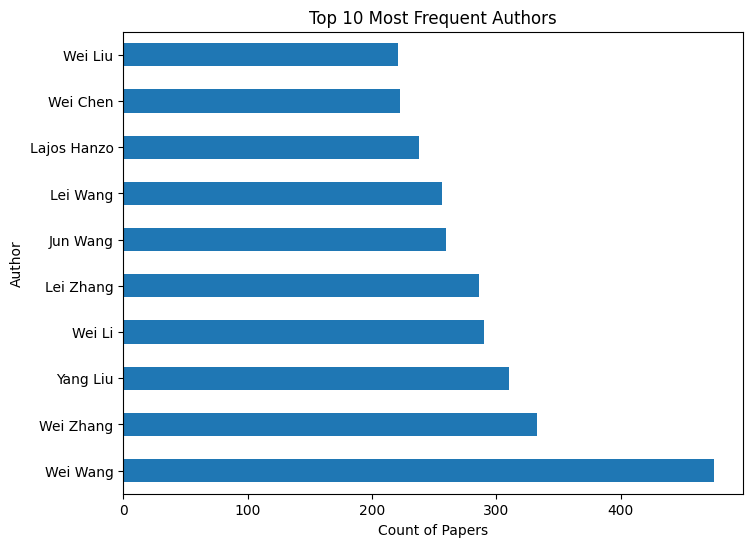

In [8]:
import matplotlib.pyplot as plt

author_counts = all_authors.value_counts().head(10)  # top 10 authors
author_counts.plot(kind='barh', figsize=(8,6))
plt.xlabel("Count of Papers")
plt.ylabel("Author")
plt.title("Top 10 Most Frequent Authors")
plt.show()

In [14]:
df.to_csv('data/data_cleaned.csv', index=False)

In [15]:
missing_abstract = df['abstract'].isnull().sum()
missing_authors = df['authors'].apply(lambda x: len(x)==0).sum()

print(f"Missing abstracts: {missing_abstract}")
print(f"Papers with no listed authors: {missing_authors}")

Missing abstracts: 0
Papers with no listed authors: 1


In [16]:
import networkx as nx

G = nx.Graph()  # or DiGraph if you want a directed graph

for idx, row in df.iterrows():
    paper_id = row['paper_id'] if 'paper_id' in df.columns else row['__index_level_0__']
    paper_title = row['title']
    abstract = row['abstract']
    
    # 1) Add Paper node
    G.add_node(
        paper_id,
        label='paper',
        title=paper_title,
        abstract=abstract
    )
    
    # 2) For each author, add an Author node and create an edge
    for author in row['authors']:
        # Add Author node
        G.add_node(
            author,
            label='author',
        )
        # Add Edge (Author -> Paper)
        G.add_edge(
            author,      # or (author, paper_id) if directed
            paper_id,
            relation='AUTHORED'
        )

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 1133092
Number of edges: 1622441


In [23]:
# Suppose you want to see which papers a particular author wrote:
author_node = "Barbara Liskov"
papers_by_author = [n for n in G.neighbors(author_node) if G.nodes[n]['label'] == 'paper']
print(f"Papers by {author_node}:\n", papers_by_author)

Papers by Barbara Liskov:
 [9512, 495635, 654482, 389673, 494086, 348139, 196500, 382440, 383133, 178623, 246529, 522691, 393061, 121085, 382950, 115368, 307849, 810727]


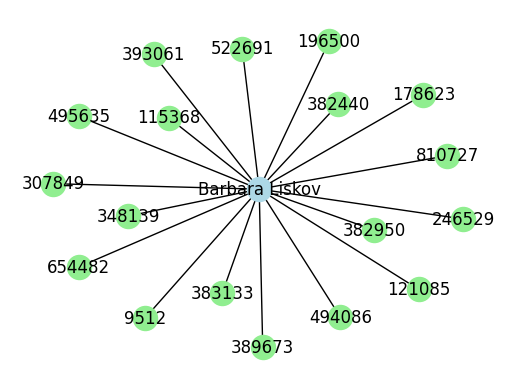

In [24]:
import matplotlib.pyplot as plt

# Subgraph for quick visualization
sub_nodes = list(papers_by_author) + [author_node]
H = G.subgraph(sub_nodes)

pos = nx.spring_layout(H)
author_nodes = [node for node in H if H.nodes[node]['label'] == 'author']
paper_nodes = [node for node in H if H.nodes[node]['label'] == 'paper']

nx.draw_networkx_nodes(H, pos, nodelist=author_nodes, node_color='lightblue')
nx.draw_networkx_nodes(H, pos, nodelist=paper_nodes, node_color='lightgreen')
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.axis('off')
plt.show()